In [ ]:
#|default_exp init_swish

# Initialization

In [ ]:
%env PYTORCH_ENABLE_MPS_FALLBACK 1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)


In [ ]:
from miniai.mps import *

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

tds = cache_dataset_as_dict(dsd.with_transform(transformi))


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
bs = 1024
dls = DataLoaders.from_dd(tds, bs, num_workers=0)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]),
 tensor[10] i64 x∈[0, 9] μ=3.300 σ=3.129 [9, 0, 0, 3, 0, 2, 7, 2, 5, 5])

In [ ]:
from miniai.init import *

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

### Applying an init function

In [ ]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Sequential
Flatten
Sequential


In [ ]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight)
def zero_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): 
        with torch.no_grad(): 
            m.weight.zero_()
            m.bias.zero_()

## Input normalization

In [ ]:
xmean,xstd = xb.mean(),xb.std()
xmean,xstd

(tensor(0.28), tensor(0.35))

In [ ]:
#| export
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [ ]:
def _norm(b): return (b[0]-xmean)/xstd,b[1]
norm = BatchTransformCB(_norm)

In [ ]:
dls = DataLoaders.from_dd(tds, bs, num_workers=0)

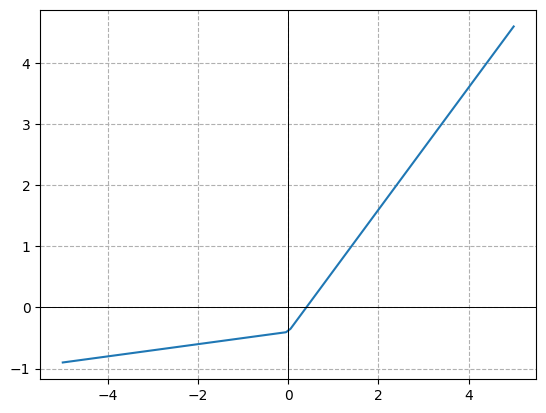

In [ ]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [ ]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

In [ ]:
#| export
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [ ]:
model = get_model(act_gr).apply(iw)

### LSUV + GLEU

In [ ]:
from miniai.init_mod import *

In [ ]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance((GeneralRelu, nn.ReLU, nn.GELU)))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

accuracy,loss,epoch,train
0.718,0.805,0,train
0.824,0.491,0,eval
0.842,0.433,1,train
0.844,0.429,1,eval
0.861,0.379,2,train
0.856,0.393,2,eval


LSUV init done on 5 layers


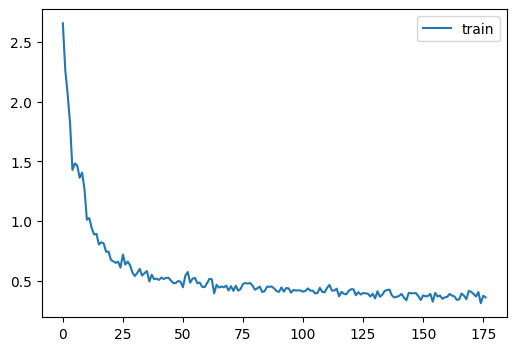

In [ ]:
set_seed(42)
model=get_model(nn.GELU).apply(orthogonal_init_orig)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs+[LSUVInit(None, eps=0.001, verbose=False)])
learn.fit(3)

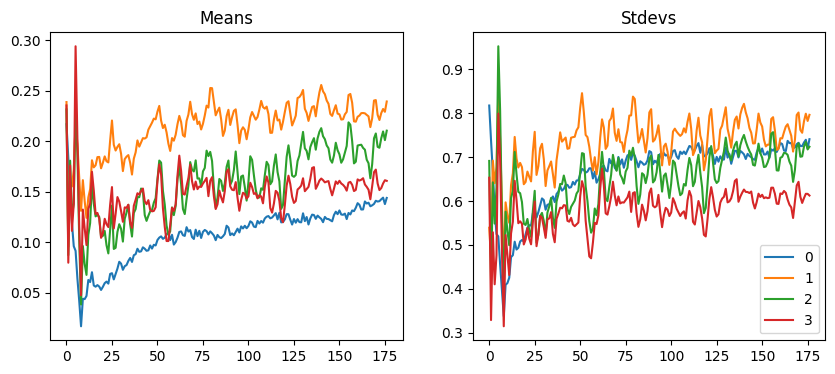

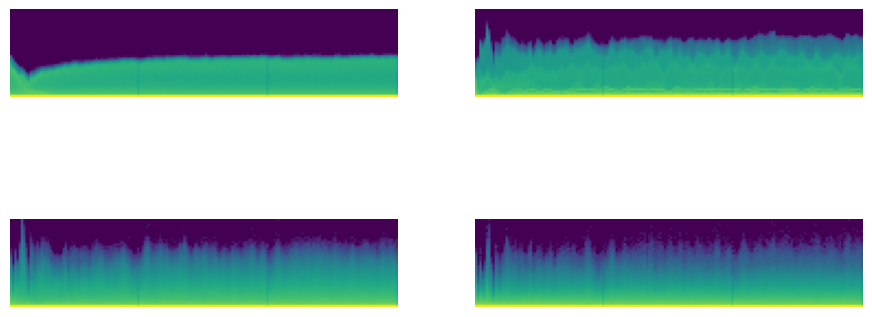

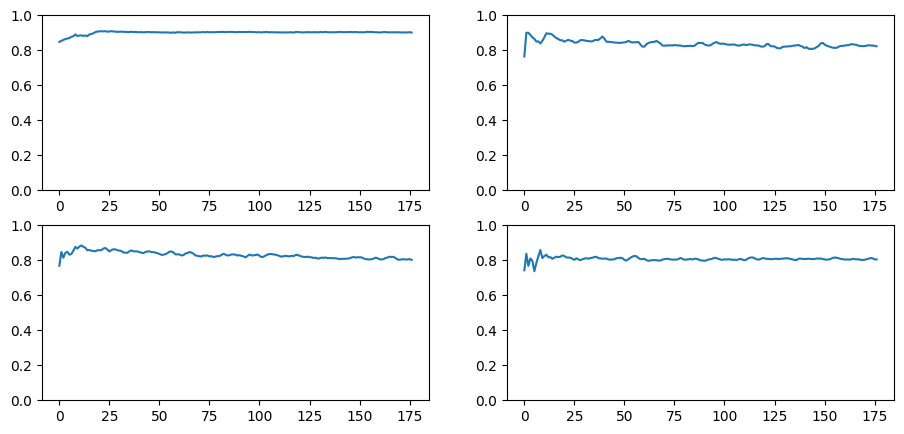

In [ ]:

astats.plot_stats();astats.color_dim();astats.dead_chart()

accuracy,loss,epoch,train
0.525,1.378,0,train
0.764,0.625,0,eval
0.800,0.531,1,train
0.811,0.503,1,eval
0.831,0.449,2,train
0.830,0.441,2,eval


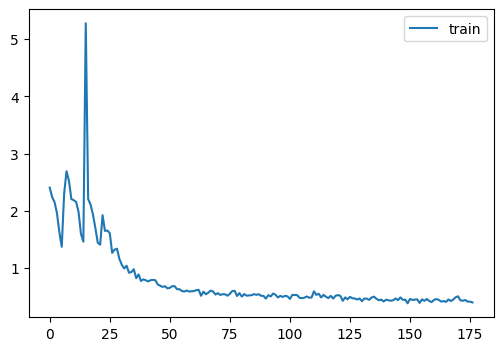

In [ ]:
set_seed(42)
model=get_model(nn.GELU()).apply(init_weights)
model.lsuv_init=True
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs+[LSUVInit(eps=1000, verbose=True)])
learn.fit(3)

In [ ]:
iw

functools.partial(<function init_weights>, leaky=0.1)

accuracy,loss,epoch,train
0.734,0.758,0,train
0.844,0.434,0,eval
0.863,0.376,1,train
0.858,0.381,1,eval
0.880,0.328,2,train
0.871,0.354,2,eval


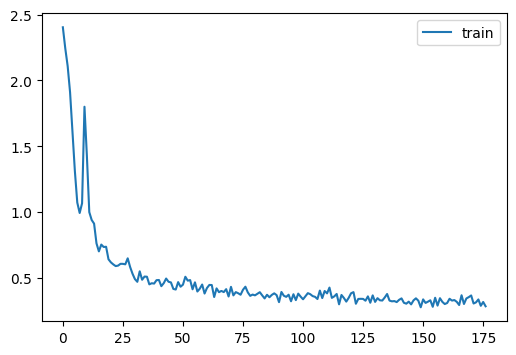

In [ ]:
def kaiming_normal_bias0(m, a=0):    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if hasattr(m, 'weight'):
            #nn.init.uniform_(m.weight.data, -1.0, 1)
            nn.init.kaiming_normal_(m.weight, a=a)
            try:
                nn.init.constant_(m.bias, 0)
            except AttributeError:
                print('no bias at ', m)

set_seed(42)
model=get_model(act_gr).apply(partial(kaiming_normal_bias0, a=0.1))
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.761,0.661,0,train
0.845,0.431,0,eval
0.862,0.374,1,train
0.863,0.383,1,eval
0.878,0.333,2,train
0.866,0.370,2,eval


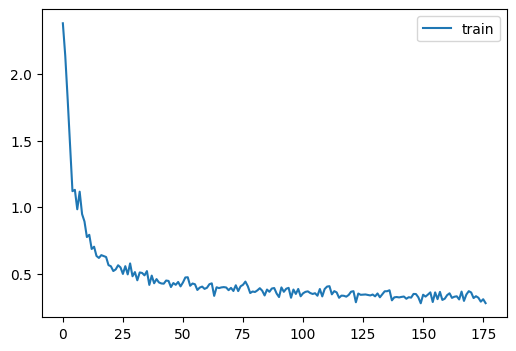

In [ ]:
def kaming_uniform_bias0(m, a=0):    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if hasattr(m, 'weight'):
            #nn.init.uniform_(m.weight.data, -1.0, 1)
            nn.init.kaiming_uniform_(m.weight.data, a=a)
            try:
                nn.init.constant_(m.bias, 0)
            except:
                pass

set_seed(42)
model=get_model(act_gr).apply(partial(kaming_uniform_bias0, a=0.1))
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.252,2.286,0,train
0.100,2.359,0,eval
0.140,2.281,1,train
0.356,1.906,1,eval
0.583,1.145,2,train
0.734,0.727,2,eval


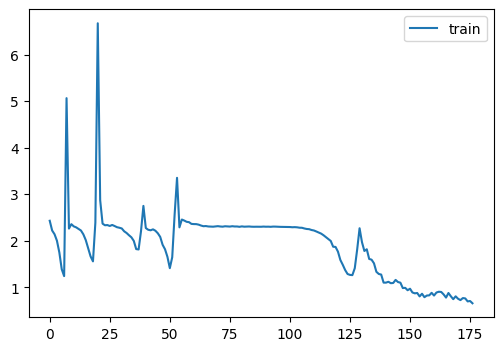

In [ ]:
set_seed(42)
model = get_model(act_gr).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.378,1.765,0,train
0.717,0.781,0,eval
0.785,0.574,1,train
0.808,0.523,1,eval
0.827,0.466,2,train
0.840,0.446,2,eval


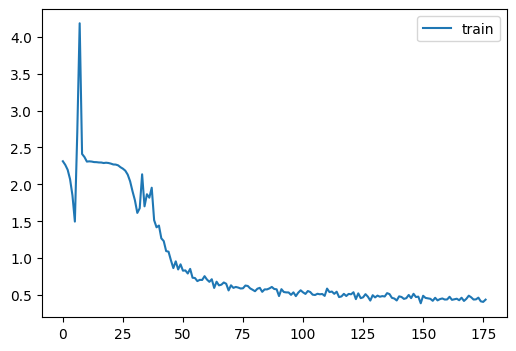

In [ ]:
set_seed(42)
model=get_model(act_gr).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

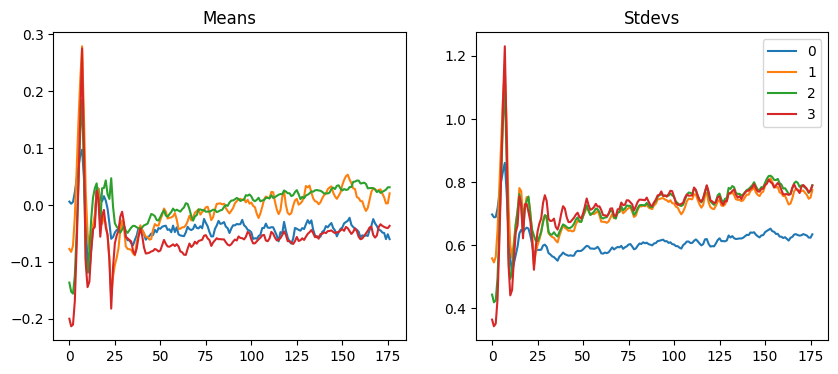

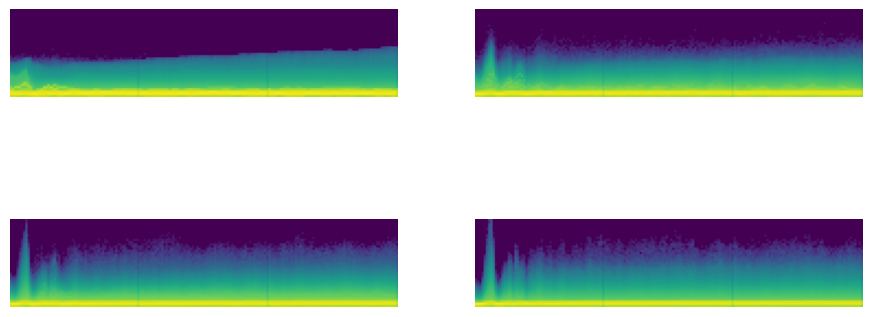

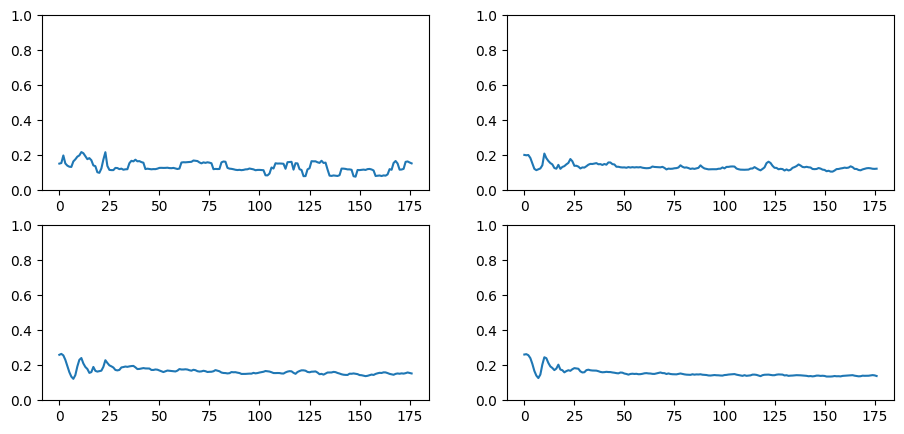

In [ ]:
astats.plot_stats();astats.color_dim();astats.dead_chart()

In [ ]:
bs = 1024
dls = DataLoaders.from_dd(tds, bs, num_workers=0)

## GLEU

accuracy,loss,epoch,train
0.675,0.979,0,train
0.830,0.476,0,eval
0.853,0.400,1,train
0.853,0.397,1,eval
0.872,0.348,2,train
0.865,0.369,2,eval


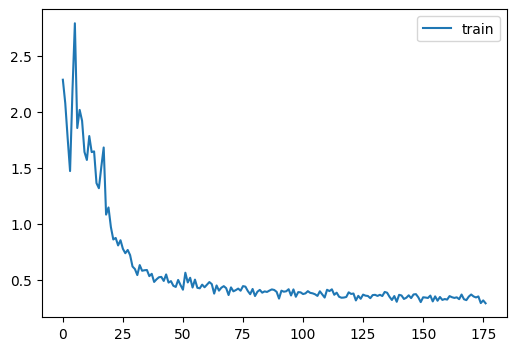

In [ ]:
set_seed(42)
model = get_model(nn.GELU).apply(init_weights)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
#learn.lr_find()
learn.fit(3)

accuracy,loss,epoch,train
0.703,0.913,0,train
0.826,0.468,0,eval
0.855,0.398,1,train
0.850,0.405,1,eval
0.873,0.344,2,train
0.864,0.370,2,eval


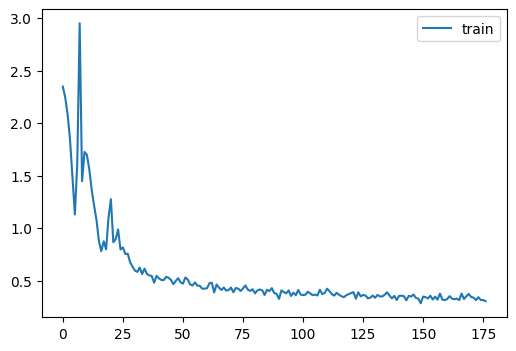

In [ ]:
set_seed(42)
model = get_model(nn.GELU).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
#learn.lr_find()
learn.fit(3)

In [ ]:
cbs

[<miniai.learner.DeviceCB>,
 <miniai.learner.MetricsCB>,
 <miniai.learner.ProgressCB>,
 <miniai.activations.ActivationStats>]

accuracy,loss,epoch,train
0.716,0.845,0,train
0.827,0.470,0,eval
0.851,0.404,1,train
0.850,0.415,1,eval
0.872,0.350,2,train
0.868,0.367,2,eval


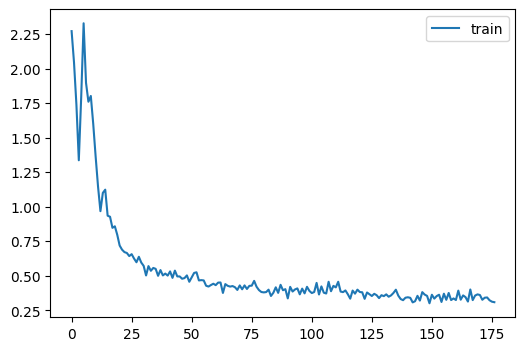

In [ ]:
set_seed(42)
model = get_model(nn.GELU).apply(kaiming_normal_bias0)
#set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
#learn.lr_find()
learn.fit(3)

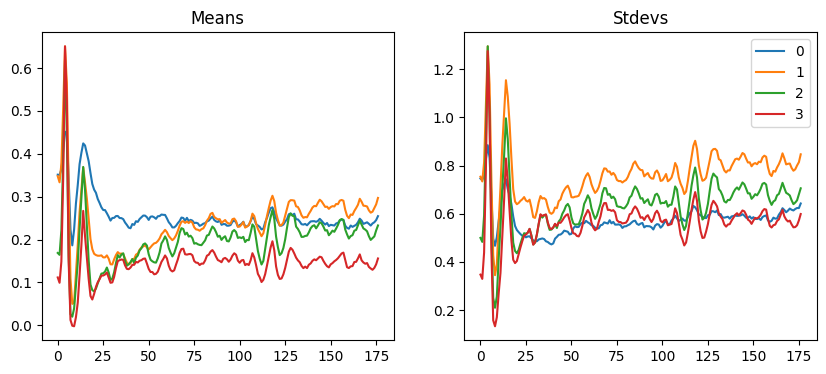

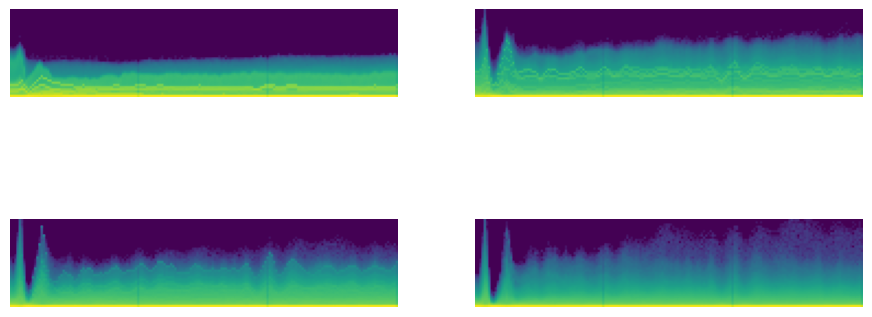

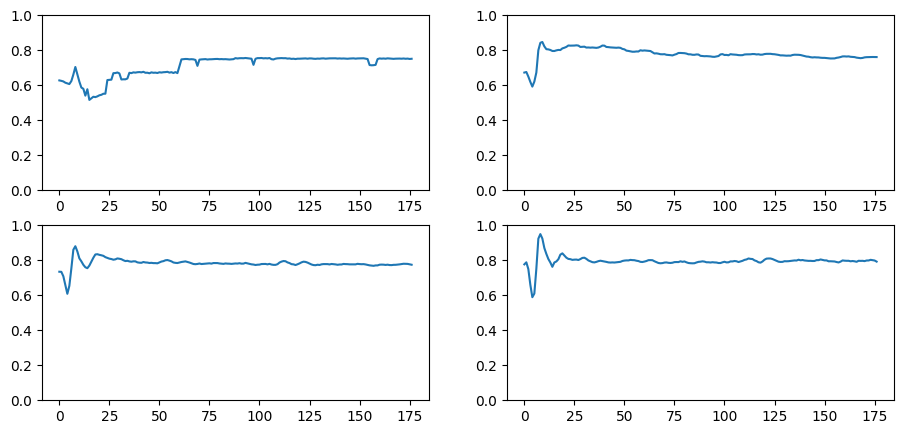

In [ ]:

astats.plot_stats();astats.color_dim();astats.dead_chart()

/opt/homebrew/Caskroom/mambaforge/base/envs/miniai/lib/python3.10/site-packages/torch/nn/init.py:484: UserWarning: The operator 'aten::linalg_qr.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  q, r = torch.linalg.qr(flattened)


accuracy,loss,epoch,train
0.694,0.882,0,train
0.822,0.479,0,eval
0.851,0.407,1,train
0.849,0.407,1,eval
0.869,0.355,2,train
0.858,0.388,2,eval


LSUV init done on 5 layers


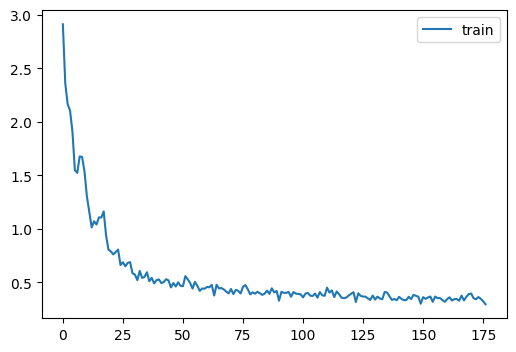

In [ ]:
set_seed(42)
model=get_model(nn.GELU).apply(orthogonal_init)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs+[LSUVInit(None, eps=0.001, verbose=False)])
learn.fit(3)

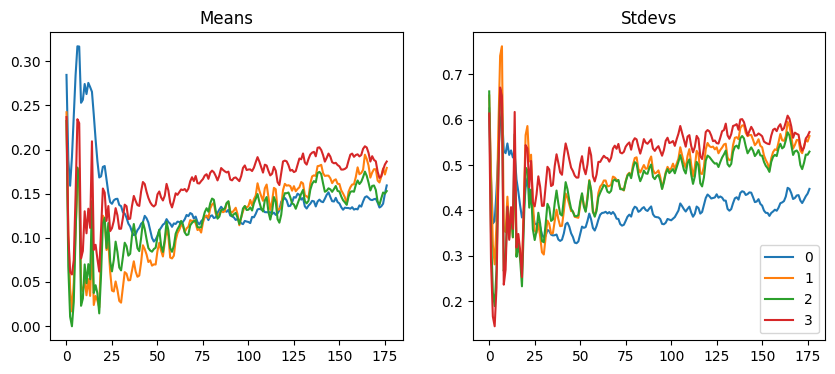

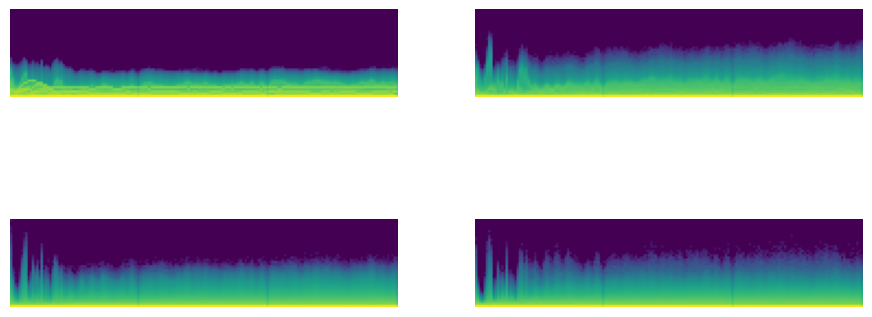

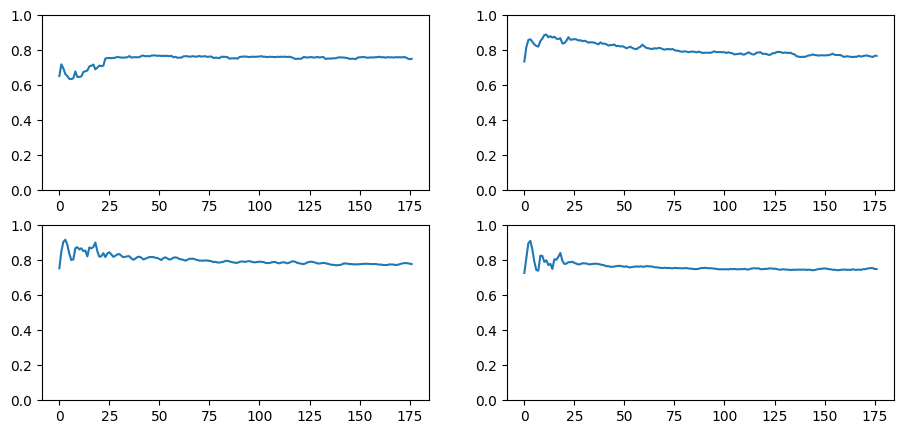

In [ ]:

astats.plot_stats();astats.color_dim();astats.dead_chart()

## GELU with sub 

In [ ]:
#| export
class GeneralGelu(nn.Module):
    def __init__(self, sub=None, maxv=None):
        super().__init__()
        self.sub,self.maxv = sub,maxv

    def forward(self, x): 
        x = F.gelu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

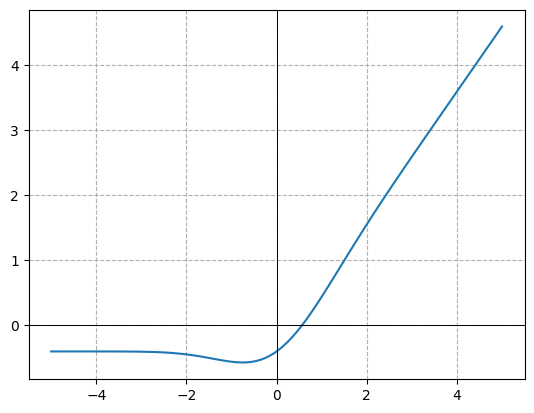

In [ ]:
plot_func(GeneralGelu(sub=0.4))

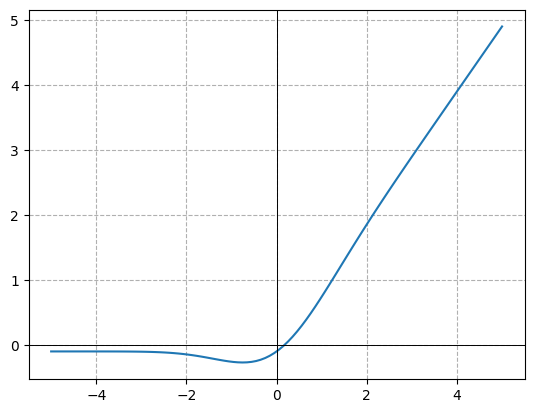

In [ ]:
plot_func(GeneralGelu(sub=0.1))

accuracy,loss,epoch,train
0.776,0.623,0,train
0.849,0.415,0,eval
0.868,0.362,1,train
0.862,0.377,1,eval
0.884,0.317,2,train
0.871,0.349,2,eval


LSUV init done on 5 layers


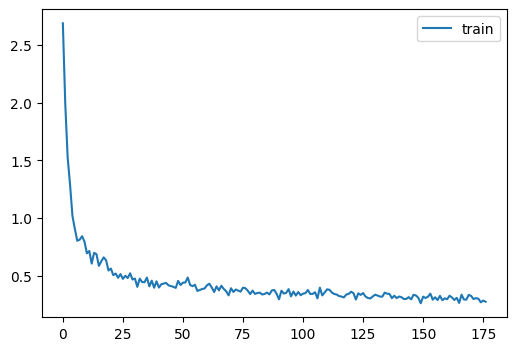

In [ ]:
set_seed(42)
model=get_model(partial(GeneralGelu, sub=0.4)).apply(orthogonal_init)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs+[LSUVInit(None, eps=0.001, verbose=False)])
learn.fit(3)

accuracy,loss,epoch,train
0.770,0.632,0,train
0.849,0.426,0,eval
0.866,0.366,1,train
0.858,0.393,1,eval
0.881,0.325,2,train
0.868,0.367,2,eval


LSUV init done on 5 layers


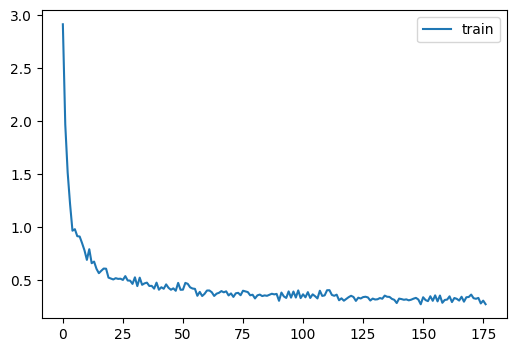

In [ ]:
#set_seed(42)
model=get_model(partial(GeneralGelu, sub=0.4)).apply(orthogonal_init)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs+[LSUVInit(None, eps=0.001, verbose=False)])
learn.fit(3)

accuracy,loss,epoch,train
0.747,0.714,0,train
0.840,0.435,0,eval
0.866,0.370,1,train
0.862,0.377,1,eval
0.882,0.325,2,train
0.869,0.363,2,eval


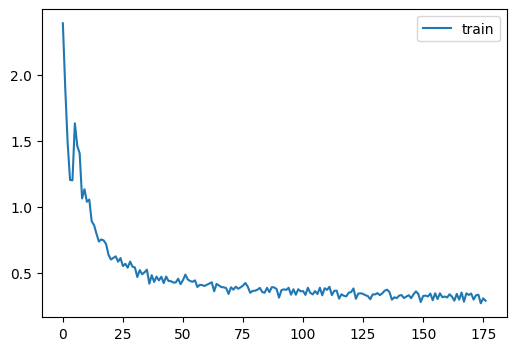

In [ ]:
#set_seed(42)
model=get_model(act_gr).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.756,0.674,0,train
0.845,0.424,0,eval
0.867,0.365,1,train
0.860,0.386,1,eval
0.882,0.322,2,train
0.869,0.359,2,eval


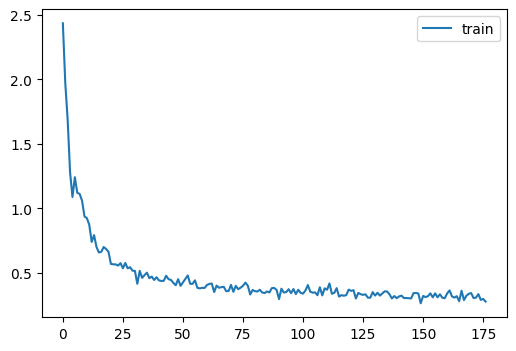

In [ ]:
set_seed(42)
model=get_model(partial(GeneralGelu, sub=0.4)).apply(init_weights)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.703,0.844,0,train
0.845,0.432,0,eval
0.863,0.372,1,train
0.853,0.394,1,eval
0.880,0.323,2,train
0.867,0.357,2,eval


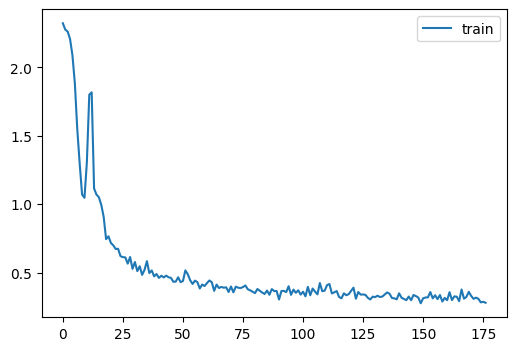

In [ ]:
set_seed(42)
model=get_model(partial(GeneralGelu, sub=0.4)).apply(orthogonal_init)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.754,0.684,0,train
0.847,0.422,0,eval
0.867,0.365,1,train
0.862,0.379,1,eval
0.883,0.322,2,train
0.864,0.371,2,eval


LSUV init done on 5 layers


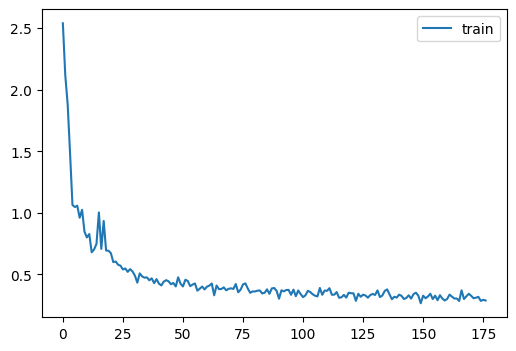

In [ ]:
set_seed(42)
model=get_model(partial(GeneralGelu, sub=0.4)).apply(orthogonal_init_orig)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs+[LSUVInit(our_model_layers, eps=0.001, verbose=False)])
learn.fit(3)

## Batch Normalization

Sergey Ioffe and Christian Szegedy released ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167) in 2015, saying:

> Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their proposal is:

> Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

### LayerNorm

We'll start with [layer normalization](https://arxiv.org/abs/1607.06450), a simpler technique.

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [ ]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [ ]:
#|export
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.719,0.919,0,train
0.825,0.481,0,eval
0.853,0.402,1,train
0.854,0.400,1,eval
0.873,0.348,2,train
0.863,0.376,2,eval


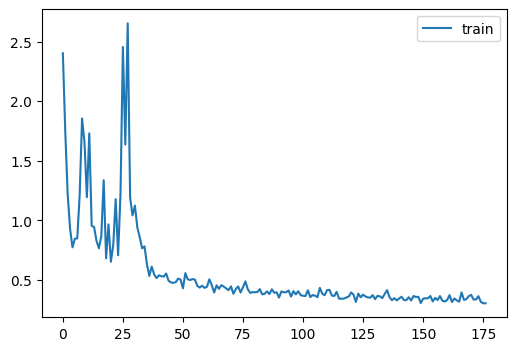

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

### BatchNorm

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

accuracy,loss,epoch,train
0.786,0.587,0,train
0.818,0.472,0,eval
0.869,0.358,1,train
0.857,0.397,1,eval
0.883,0.321,2,train
0.864,0.383,2,eval


/var/folders/q_/6ypbtk8976j5j9zhzn30df440000gn/T/ipykernel_59945/2861850682.py:14: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  self.means.lerp_(m, self.mom)


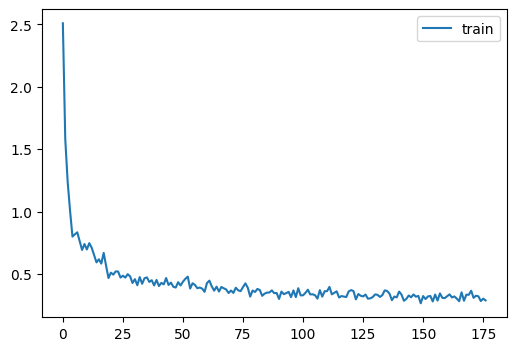

In [ ]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

![Various norms](images/norms.png)

## Towards 90%...

In [ ]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)

accuracy,loss,epoch,train
0.834,0.458,0,train
0.846,0.427,0,eval
0.881,0.324,1,train
0.867,0.373,1,eval


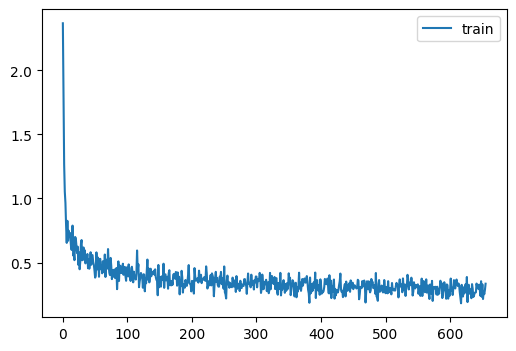

KeyboardInterrupt: 

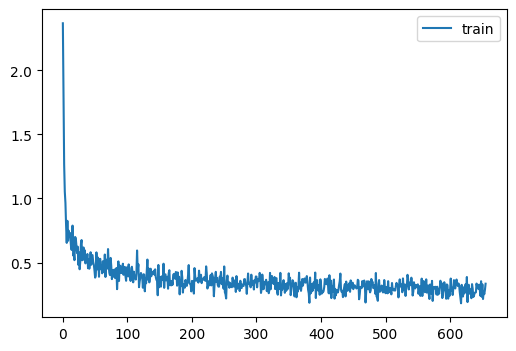

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.916,0.228,0,train
0.897,0.289,0,eval
0.921,0.214,1,train
0.898,0.288,1,eval


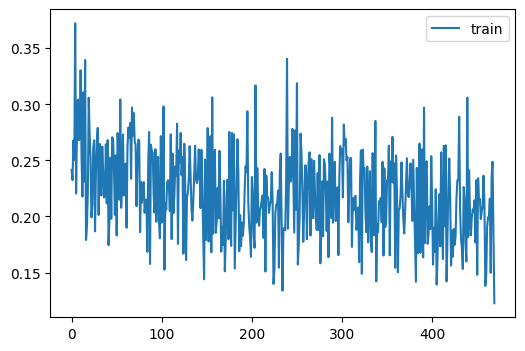

In [ ]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()